## 1. Import and observe dataset
<p>We all love watching movies! There are some movies we like, some we don't. Most people have a preference for movies of a similar genre. Some of us love watching action movies, while some of us like watching horror. Some of us like watching movies that have ninjas in them, while some of us like watching superheroes.</p>
<p>Movies within a genre often share common base parameters. Consider the following two movies:</p>
<p><img style="margin:5px 20px 5px 1px; height: 250px; display: inline-block;" alt="2001: A Space Odyssey" src="https://assets.datacamp.com/production/project_648/img/movie1.jpg">
<img style="margin:5px 20px 5px 1px; height: 250px; display: inline-block;" alt="Close Encounters of the Third Kind" src="https://assets.datacamp.com/production/project_648/img/movie2.jpg"></p>
<p>Both movies, <em>2001: A Space Odyssey</em> and <em>Close Encounters of the Third Kind</em>, are movies based on aliens coming to Earth. I've seen both, and they indeed share many similarities. We could conclude that both of these fall into the same genre of movies based on intuition, but that's no fun in a data science context. In this notebook, we will quantify the similarity of movies based on their plot summaries available on IMDb and Wikipedia, then separate them into groups, also known as clusters. We'll create a dendrogram to represent how closely the movies are related to each other.</p>
<p>Let's start by importing the dataset and observing the data provided.</p>

In [1]:
# Import modules
import numpy as np
import pandas as pd
import nltk

# Set seed for reproducibility
np.random.seed(5)

# Read in IMDb and Wikipedia movie data (both in same file)
movies_df = pd.read_csv("datasets/movies.csv")

print("Number of movies loaded: %s " % (len(movies_df)))

# Display the data
movies_df

Number of movies loaded: 100 


,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."
...,...,...,...,...,...
95,95,Rebel Without a Cause,[u' Drama'],\n\n\n\nJim Stark is in police custody.\n\n \...,Shortly after moving to Los Angeles with his p...
96,96,Rear Window,"[u' Mystery', u' Thriller']",\n\n\n\nJames Stewart as L.B. Jefferies\n\n \...,"L.B. ""Jeff"" Jeffries (James Stewart) recuperat..."
97,97,The Third Man,"[u' Film-Noir', u' Mystery', u' Thriller']",\n\n\n\nSocial network mapping all major chara...,"Sights of Vienna, Austria, flash across the sc..."
98,98,North by Northwest,"[u' Mystery', u' Thriller']",Advertising executive Roger O. Thornhill is mi...,"At the end of an ordinary work day, advertisin..."


## 2. Combine Wikipedia and IMDb plot summaries
<p>The dataset we imported currently contains two columns titled <code>wiki_plot</code> and <code>imdb_plot</code>. They are the plot found for the movies on Wikipedia and IMDb, respectively. The text in the two columns is similar, however, they are often written in different tones and thus provide context on a movie in a different manner of linguistic expression. Further, sometimes the text in one column may mention a feature of the plot that is not present in the other column. For example, consider the following plot extracts from <em>The Godfather</em>:</p>
<ul>
<li>Wikipedia: "On the day of his only daughter's wedding, Vito Corleone"</li>
<li>IMDb: "In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie"</li>
</ul>
<p>While the Wikipedia plot only mentions it is the day of the daughter's wedding, the IMDb plot also mentions the year of the scene and the name of the daughter. </p>
<p>Let's combine both the columns to avoid the overheads in computation associated with extra columns to process.</p>

In [2]:
# Combine wiki_plot and imdb_plot into a single column
movies_df["plot"] = movies_df["wiki_plot"].astype(str) + "\n" + \
                 movies_df["imdb_plot"].astype(str)

# Inspect the new DataFrame
movies_df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


## 3. Tokenization
<p>Tokenization is the process  by which we break down articles into individual sentences or words, as needed. Besides the tokenization method provided by NLTK, we might have to perform additional filtration to remove tokens which are entirely numeric values or punctuation.</p>
<p>While a program may fail to build context from "While waiting at a bus stop in 1981" (<em>Forrest Gump</em>), because this string would not match in any dictionary, it is possible to build context from the words "while", "waiting" or "bus" because they are present in the English dictionary. </p>
<p>Let us perform tokenization on a small extract from <em>The Godfather</em>.</p>

In [3]:
# Tokenize a paragraph into sentences and store in sent_tokenized
sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """)]

# Word Tokenize first sentence from sent_tokenized, save as words_tokenized
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]

# Remove tokens that do not contain any letters from words_tokenized
import re

filtered = [word for word in words_tokenized if re.search('[a-zA-Z]', word)]

# Display filtered words to observe words after tokenization
filtered

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

## 4. Stemming
<p>Stemming is the process by which we bring down a word from its different forms to the root word. This helps us establish meaning to different forms of the same words without having to deal with each form separately. For example, the words 'fishing', 'fished', and 'fisher' all get stemmed to the word 'fish'.</p>
<p>Consider the following sentences:</p>
<ul>
<li>"Young William Wallace witnesses the treachery of Longshanks" ~ <em>Gladiator</em></li>
<li>"escapes to the city walls only to witness Cicero's death" ~ <em>Braveheart</em></li>
</ul>
<p>Instead of building separate dictionary entries for both witnesses and witness, which mean the same thing outside of quantity, stemming them reduces them to 'wit'.</p>
<p>There are different algorithms available for stemming such as the Porter Stemmer, Snowball Stemmer, etc. We shall use the Snowball Stemmer.</p>

In [4]:
# Import the SnowballStemmer to perform stemming
from nltk.stem.snowball import SnowballStemmer

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Print filtered to observe words without stemming
print("Without stemming: ", filtered)

# Stem the words from filtered and store in stemmed_words
stemmed_words = [stemmer.stem(word) for word in filtered]

# Print the stemmed_words to observe words after stemming
print("After stemming:   ", stemmed_words)

Without stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:    ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


## 5. Club together Tokenize & Stem
<p>We are now able to tokenize and stem sentences. But we may have to use the two functions repeatedly one after the other to handle a large amount of data, hence we can think of wrapping them in a function and passing the text to be tokenized and stemmed as the function argument. Then we can pass the new wrapping function, which shall perform both tokenizing and stemming instead of just tokenizing, as the tokenizer argument while creating the TF-IDF vector of the text.  </p>
<p>What difference does it make though? Consider the sentence from the plot of <em>The Godfather</em>: "Today (May 19, 2016) is his only daughter's wedding." If we do a 'tokenize-only' for this sentence, we have the following result:</p>
<blockquote>
  <p>'today', 'may', 'is', 'his', 'only', 'daughter', "'s", 'wedding'</p>
</blockquote>
<p>But when we do a 'tokenize-and-stem' operation we get:</p>
<blockquote>
  <p>'today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed'</p>
</blockquote>
<p>All the words are in their root form, which will lead to a better establishment of meaning as some of the non-root forms may not be present in the NLTK training corpus.</p>

In [5]:
# Define a function to perform both stemming and tokenization
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    return stems

words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


## 6. Create TfidfVectorizer
<p>Computers do not <em>understand</em> text. These are machines only capable of understanding numbers and performing numerical computation. Hence, we must convert our textual plot summaries to numbers for the computer to be able to extract meaning from them. One simple method of doing this would be to count all the occurrences of each word in the entire vocabulary and return the counts in a vector. Enter <code>CountVectorizer</code>.</p>
<p>Consider the word 'the'. It appears quite frequently in almost all movie plots and will have a high count in each case. But obviously, it isn't the theme of all the movies! <a href="https://campus.datacamp.com/courses/natural-language-processing-fundamentals-in-python/simple-topic-identification?ex=11">Term Frequency-Inverse Document Frequency</a> (TF-IDF) is one method which overcomes the shortcomings of <code>CountVectorizer</code>. The Term Frequency of a word is the measure of how often it appears in a document, while the Inverse Document Frequency is the parameter which reduces the importance of a word if it frequently appears in several documents.</p>
<p>For example, when we apply the TF-IDF on the first 3 sentences from the plot of <em>The Wizard of Oz</em>, we are told that the most important word there is 'Toto', the pet dog of the lead character. This is because the movie begins with 'Toto' biting someone due to which the journey of Oz begins!</p>
<p>In simplest terms, TF-IDF recognizes words which are unique and important to any given document. Let's create one for our purposes.</p>

In [6]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

## 7. Fit transform TfidfVectorizer
<p>Once we create a TF-IDF Vectorizer, we must fit the text to it and then transform the text to produce the corresponding numeric form of the data which the computer will be able to understand and derive meaning from. To do this, we use the <code>fit_transform()</code> method of the <code>TfidfVectorizer</code> object. </p>
<p>If we observe the <code>TfidfVectorizer</code> object we created, we come across a parameter stopwords. 'stopwords' are those words in a given text which do not contribute considerably towards the meaning of the sentence and are generally grammatical filler words. For example, in the sentence 'Dorothy Gale lives with her dog Toto on the farm of her Aunt Em and Uncle Henry', we could drop the words 'her' and 'the', and still have a similar overall meaning to the sentence. Thus, 'her' and 'the' are stopwords and can be conveniently dropped from the sentence. </p>
<p>On setting the stopwords to 'english', we direct the vectorizer to drop all stopwords from a pre-defined list of English language stopwords present in the nltk module. Another parameter, <code>ngram_range</code>, defines the length of the ngrams to be formed while vectorizing the text.</p>

In [7]:
# Fit and transform the tfidf_vectorizer with the "plot" of each movie
# to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies_df["plot"]])

print(tfidf_matrix.shape)

/Users/hermawan/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(100, 564)


## 8. Import KMeans and create clusters
<p>To determine how closely one movie is related to the other by the help of unsupervised learning, we can use clustering techniques. Clustering is the method of grouping together a number of items such that they exhibit similar properties. According to the measure of similarity desired, a given sample of items can have one or more clusters. </p>
<p>A good basis of clustering in our dataset could be the genre of the movies. Say we could have a cluster '0' which holds movies of the 'Drama' genre. We would expect movies like <em>Chinatown</em> or <em>Psycho</em> to belong to this cluster. Similarly, the cluster '1' in this project holds movies which belong to the 'Adventure' genre (<em>Lawrence of Arabia</em> and the <em>Raiders of the Lost Ark</em>, for example).</p>
<p>K-means is an algorithm which helps us to implement clustering in Python. The name derives from its method of implementation: the given sample is divided into <b><i>K</i></b> clusters where each cluster is denoted by the <b><i>mean</i></b> of all the items lying in that cluster. </p>
<p>We get the following distribution for the clusters:</p>
<p><img src="https://assets.datacamp.com/production/project_648/img/bar_clusters.png" alt="bar graph of clusters"></p>

In [8]:
# Import k-means to perform clusters
from sklearn.cluster import KMeans

# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
movies_df['cluster'].value_counts() 

2    35
1    21
3    20
0    17
4     7
Name: cluster, dtype: int64

## 9. Calculate similarity distance
<p>Consider the following two sentences from the movie <em>The Wizard of Oz</em>: </p>
<blockquote>
  <p>"they find in the Emerald City"</p>
  <p>"they finally reach the Emerald City"</p>
</blockquote>
<p>If we put the above sentences in a <code>CountVectorizer</code>, the vocabulary produced would be "they, find, in, the, Emerald, City, finally, reach" and the vectors for each sentence would be as follows: </p>
<blockquote>
  <p>1, 1, 1, 1, 1, 1, 0, 0</p>
  <p>1, 0, 0, 1, 1, 1, 1, 1</p>
</blockquote>
<p>When we calculate the cosine angle formed between the vectors represented by the above, we get a score of 0.667. This means the above sentences are very closely related. <em>Similarity distance</em> is 1 - <a href="https://en.wikipedia.org/wiki/Cosine_similarity">cosine similarity angle</a>. This follows from that if the vectors are similar, the cosine of their angle would be 1 and hence, the distance between then would be 1 - 1 = 0.</p>
<p>Let's calculate the similarity distance for all of our movies.</p>

In [9]:
# Import cosine_similarity to calculate similarity of movie plots
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

## 10. Import Matplotlib, Linkage, and Dendrograms
<p>We shall now create a tree-like diagram (called a dendrogram) of the movie titles to help us understand the level of similarity between them visually. Dendrograms help visualize the results of hierarchical clustering, which is an alternative to k-means clustering. Two pairs of movies at the same level of hierarchical clustering are expected to have similar strength of similarity between the corresponding pairs of movies. For example, the movie <em>Fargo</em> would be as similar to <em>North By Northwest</em> as the movie <em>Platoon</em> is to <em>Saving Private Ryan</em>, given both the pairs exhibit the same level of the hierarchy.</p>
<p>Let's import the modules we'll need to create our dendrogram.</p>

In [10]:
# Import matplotlib.pyplot for plotting graphs
import matplotlib.pyplot as plt

# Configure matplotlib to display the output inline
%matplotlib inline

# Import modules necessary to plot dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

## 11. Create merging and plot dendrogram
<p>We shall plot a dendrogram of the movies whose similarity measure will be given by the similarity distance we previously calculated. The lower the similarity distance between any two movies, the lower their linkage will make an intercept on the y-axis. For instance, the lowest dendrogram linkage we shall discover will be between the movies, <em>It's a Wonderful Life</em> and <em>A Place in the Sun</em>. This indicates that the movies are very similar to each other in their plots.</p>

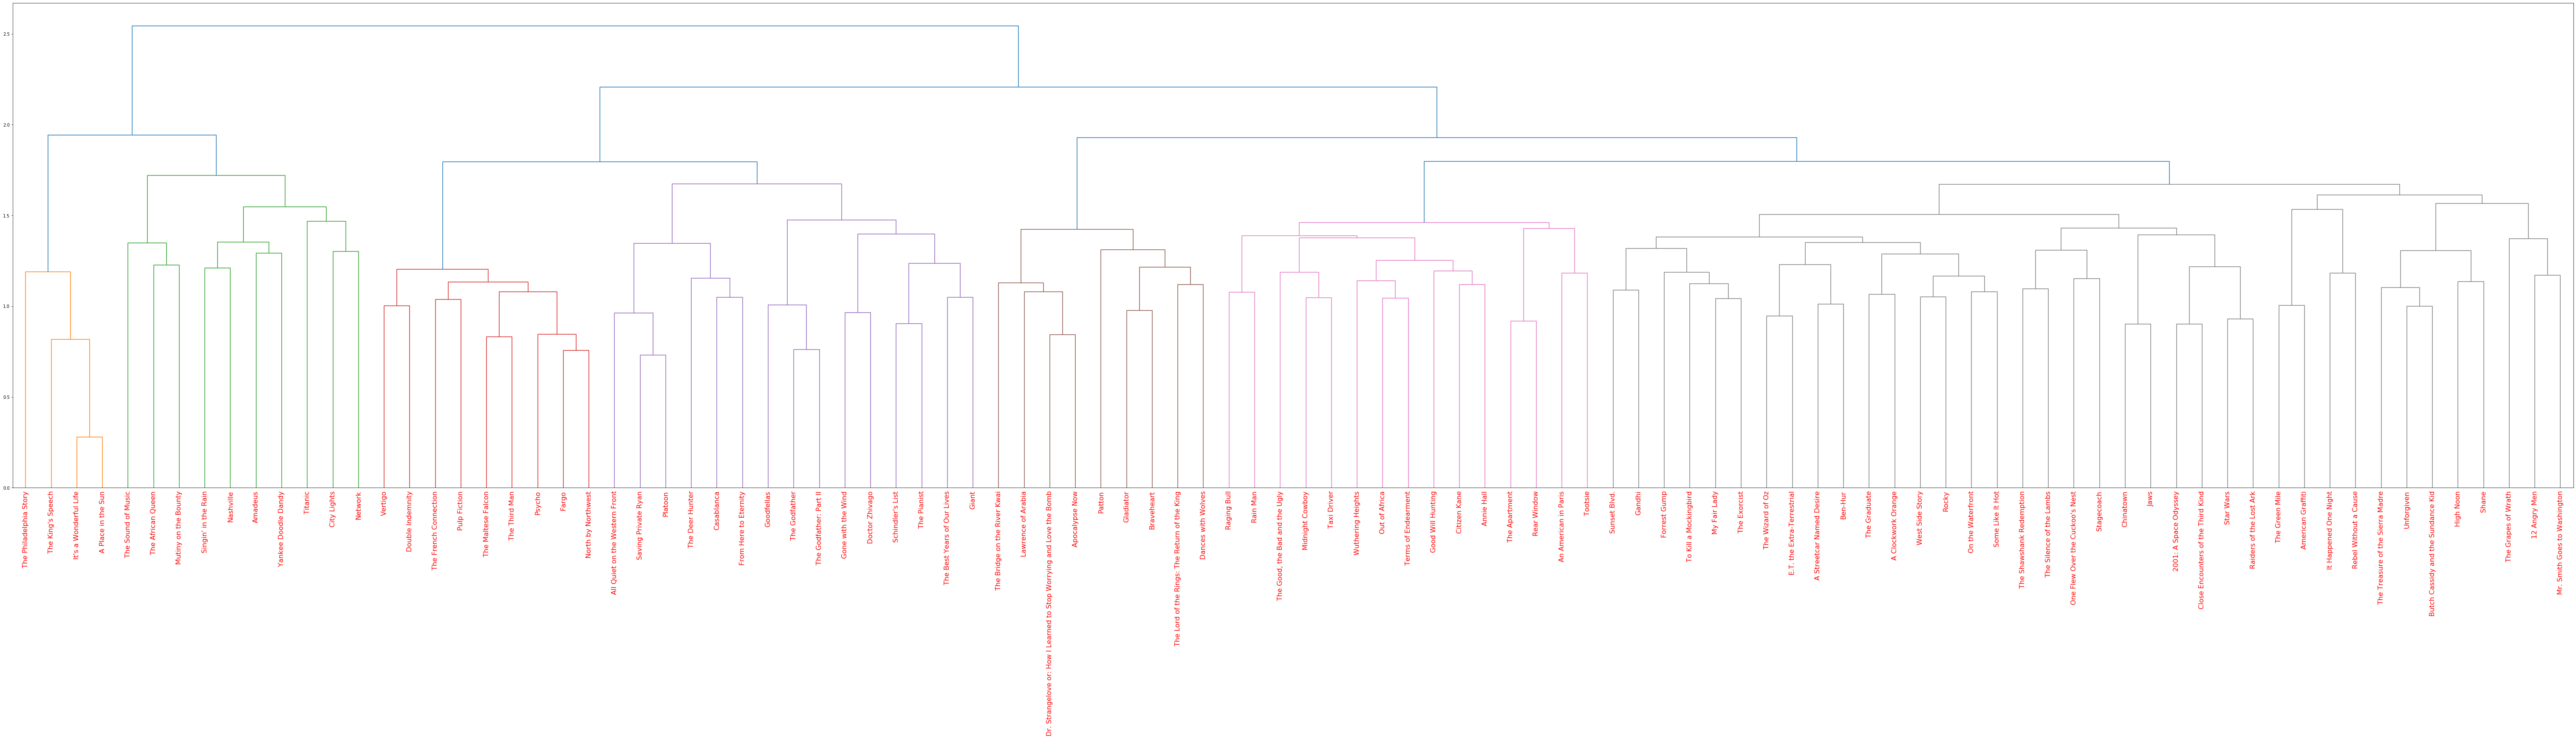

In [11]:
# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in movies_df["title"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

# Show the plotted dendrogram
plt.show()

## 12. Which movies are most similar?
<p>We can now determine the similarity between movies based on their plots! To wrap up, let's answer one final question: which movie is most similar to the movie <em>Braveheart</em>?</p>

In [12]:
# Answer the question 
ans = "Braveheart"
print(ans)

Braveheart
